In [1]:

#Imports
from sklearn.model_selection import KFold, train_test_split

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import keras
from keras.models import Model
from keras import optimizers
from keras import layers

import scipy.io
import random
import pdb

2023-04-26 22:00:17.506918: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-26 22:00:17.660821: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-26 22:00:17.661964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 22:00:18.671655: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
#verify if we are using the gpu
tf.test.gpu_device_name()

''

In [3]:
#Load brain-wave data from Drive. The data is from a BCI device that recorded 
#brain wave data at at rate of 512hz from 11 channels and from 6 different 
#people who wore the device.

data_mat = scipy.io.loadmat("Data.mat")

fear_data_raw = data_mat["Data"]["Fear"][0][0]
fear_data_raw = np.array(fear_data_raw / 10000, dtype=np.float64)
nervous_data_raw = data_mat["Data"]["Nervous"][0][0]
nervous_data_raw = np.array(nervous_data_raw / 10000, dtype=np.float64)

raw_data_source = fear_data_raw

bci_sampling_rate = 512
datapoint_len_seconds = 1
input_length = bci_sampling_rate * datapoint_len_seconds

In [4]:
#Process the data. Apply min-max normalization across the x-axis of the data
#for each person and channel. Additonally, group the data by input_length

def apply_min_max_norm(data_raw):
    for person_index in range(data_raw.shape[2]):
        for channel_index in range(data_raw.shape[1]):
            values = data_raw[:, channel_index, person_index]
            data_raw[:, channel_index, person_index] = (values - values.min()) / (values.max() - values.min())
    
    return raw_data_source

raw_data_source = apply_min_max_norm(raw_data_source)

x_data_len = (raw_data_source.shape[0] / input_length) * raw_data_source.shape[1] * raw_data_source.shape[2]
x_data_len = int(x_data_len)
x_data = np.zeros((x_data_len, input_length))

#format x_data such all of the brain wave data from one channel and one person 
#is stacked ontop of the brainwave data from one other person/channel
i = 0
for c_index in range(raw_data_source.shape[1]):
    for p_index in range(raw_data_source.shape[2]):
        iter_count = int(raw_data_source.shape[0] / input_length)
        
        for i_iter in range(iter_count):
            
            lower_bound = i_iter * input_length
            upper_bound = (i_iter + 1) * input_length
           
            #print(f"{i} {i_iter} {c_index} {p_index}")
            x_data[i + i_iter] = raw_data_source[lower_bound:upper_bound, c_index, p_index]
        
        i += iter_count

In [5]:
#We will be using an autoencoder as a sort of automatic "feature" generation.
#Having a lower number of data-points with the expectation that it will improve
#the accuracy of our regular feed-forward network that predicts emotional states

#this implementation is based off of this blog:
#https://blog.keras.io/building-autoencoders-in-keras.html

optimizer = optimizers.Adam(0.0002, 0.5)
encoded_data_dim = 64

def build_autoencoder(input_size):
  input_layer = layers.Input(shape=(input_size,))
  flatten_layer = layers.Flatten()(input_layer)
  encoder = layers.Dense(256, activation="relu")(flatten_layer)
  encoder = layers.Dense(128, activation="relu")(encoder)
  encoder = layers.Dense(encoded_data_dim, activation="relu", name="encoder_output")(encoder)

  decoder = layers.Dense(128, activation="relu")(encoder)
  decoder = layers.Dense(256, activation="relu")(decoder)
  decoder = layers.Dense(input_size, activation="sigmoid")(decoder)

  autoencoder = keras.Model(input_layer, decoder)
  autoencoder.compile(optimizer="adam", loss="mse", metrics=["mae"])

  return autoencoder

In [6]:
#training parameters
batch_size = 32
epoch_count = 50

Epoch 1/50
567/567 [==============================] - 3s 4ms/step - loss: 0.0078 - mae: 0.0440
Epoch 2/50
567/567 [==============================] - 2s 4ms/step - loss: 5.5328e-04 - mae: 0.0155
Epoch 3/50
567/567 [==============================] - 2s 4ms/step - loss: 4.2864e-04 - mae: 0.0135
Epoch 4/50
567/567 [==============================] - 2s 4ms/step - loss: 3.1497e-04 - mae: 0.0115
Epoch 5/50
567/567 [==============================] - 2s 4ms/step - loss: 3.0929e-04 - mae: 0.0113
Epoch 6/50
567/567 [==============================] - 2s 4ms/step - loss: 2.7956e-04 - mae: 0.0108
Epoch 7/50
567/567 [==============================] - 2s 4ms/step - loss: 2.4440e-04 - mae: 0.0100
Epoch 8/50
567/567 [==============================] - 2s 4ms/step - loss: 2.3577e-04 - mae: 0.0099
Epoch 9/50
567/567 [==============================] - 2s 4ms/step - loss: 2.4080e-04 - mae: 0.0100
Epoch 10/50
567/567 [==============================] - 2s 4ms/step - loss: 2.3277e-04 - mae: 0.0099
Epoch 11/50
5

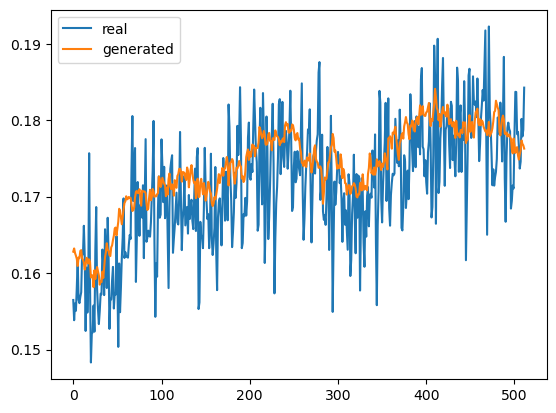

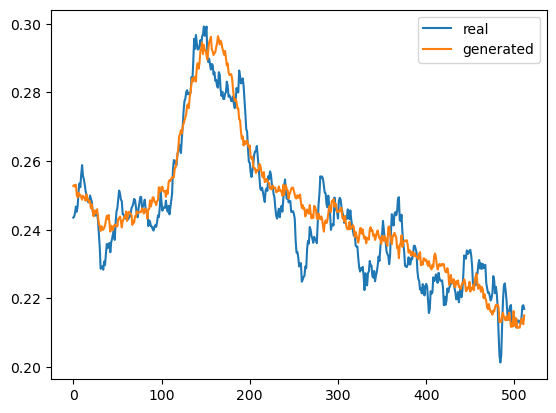

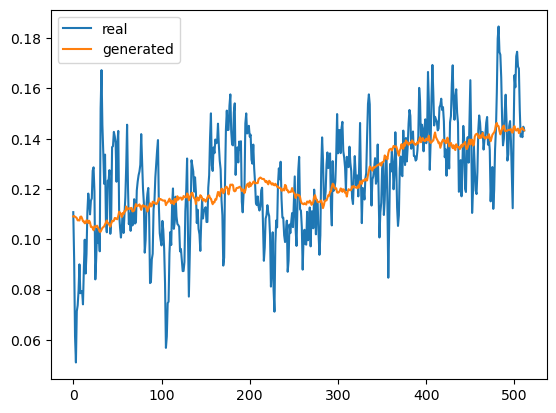

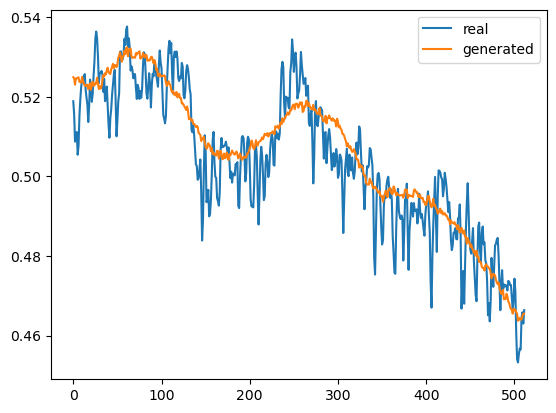

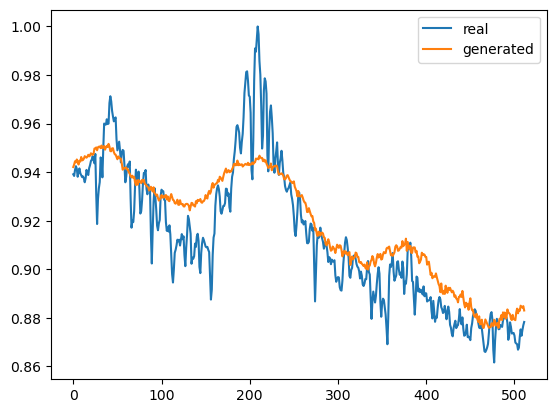

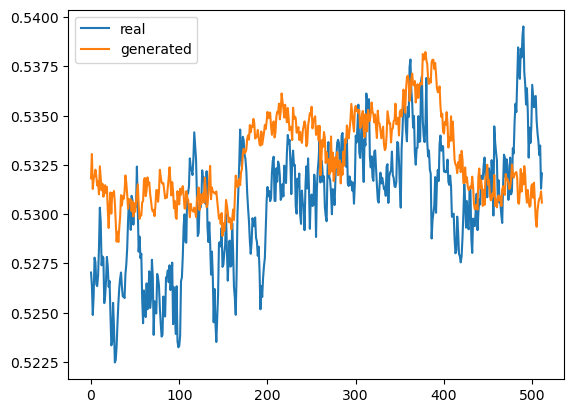

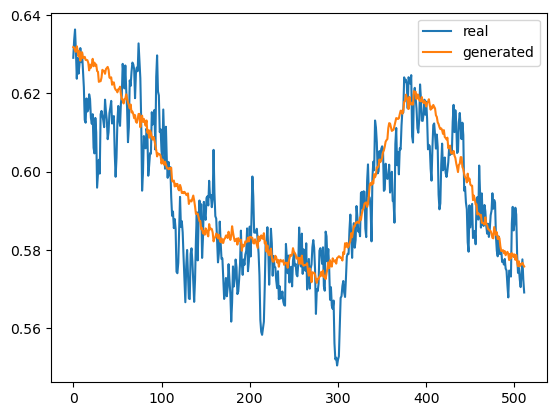

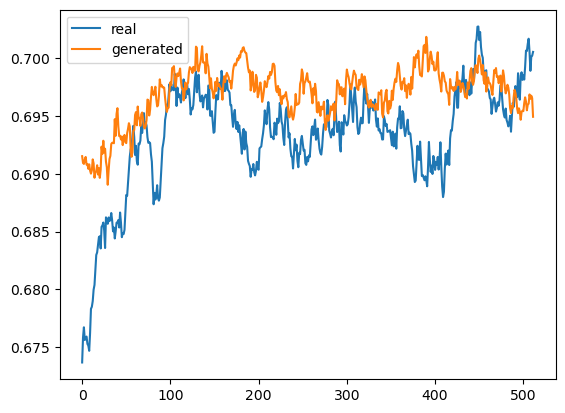

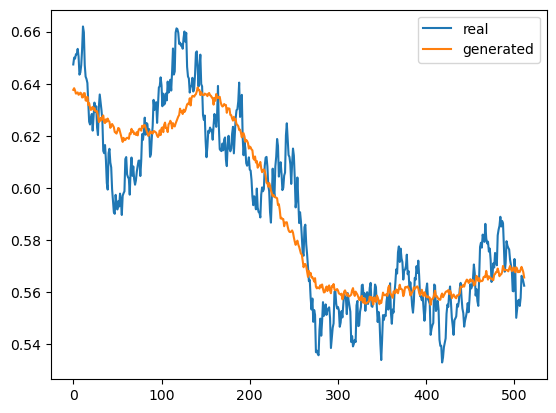

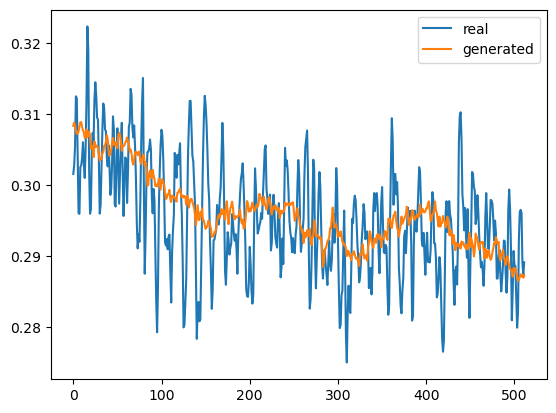

In [7]:
#Visualize the outputs of the autoencoder and see how they accurate they are.
graph_count = 5

x_data_split = train_test_split(x_data, shuffle=True, test_size=10)
autoencoder = build_autoencoder(input_length)
autoencoder.fit(x_data_split[0], x_data_split[0], batch_size=batch_size, epochs=epoch_count)

autoencoder.summary()

for test_data in x_data_split[1]:
  predicted_x = autoencoder.predict(test_data.reshape((1, input_length)))

  fig, ax = plt.subplots()
  ax.plot(np.arange(input_length), test_data, label="real")
  ax.plot(np.arange(input_length), predicted_x[0], label="generated")
  ax.legend()


In [8]:
#Using the "encoder" of th autoencoder, encode the dataset and create a new file
#with the encoded data

num_inputs = int(raw_data_source.shape[0] / input_length)
encoded_data = np.zeros((num_inputs * encoded_data_dim, raw_data_source.shape[1], raw_data_source.shape[2]))

encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("encoder_output").output)

batch_size = 32
num_inputs = 64
num_batches = int(np.ceil(num_inputs / batch_size))

channel_count = raw_data_source.shape[1]
person_count = raw_data_source.shape[2]

# for time in range(num_inputs):
#   for channel in range(raw_data_source.shape[1]):
#     for person in range(raw_data_source.shape[2]):
#       source_lr = time * input_length
#       source_ur = source_lr + input_length

#       encoded_lr = time * encoded_data_dim
#       encoded_ur = encoded_lr + encoded_data_dim

#       input_data = raw_data_source[source_lr:source_ur, channel, person].reshape(1, -1)
#       encoded_input = encoder.predict(input_data)[0]
#       pdb.set_trace()
#       encoded_data[encoded_lr:encoded_ur, channel, person] = encoded_input

for i in range(num_batches):
  batch_start = i * batch_size
  batch_end = min((i + 1) * batch_size, num_inputs)

  total_batch_size = (batch_end-batch_start) * channel_count * person_count
  input_data_batch = np.zeros((total_batch_size, input_length))
  
  for time in range(batch_start, batch_end):
    for channel in range(channel_count):
      for person in range(person_count):
        source_lr = time * input_length
        source_ur = source_lr + input_length

        #pdb.set_trace()
        #print(f"{time} {channel} {person}")

        input_data_batch[time-batch_start + channel + person, :] = raw_data_source[source_lr:source_ur, channel, person].reshape(1, -1)

  encoded_data_batch = encoder.predict_on_batch(input_data_batch)

  #pdb.set_trace()

  for time in range(batch_start, batch_end):
    for channel in range(channel_count):
      for person in range(person_count):
        encoded_lr = time * encoded_data_dim
        encoded_ur = encoded_lr + encoded_data_dim

        encoded_data[encoded_lr:encoded_ur, channel, person] = encoded_data_batch[time-batch_start + channel + person]
      
  print(f"batch {i} / {num_batches}")

scipy.io.savemat("encoded_data.mat", mdict={'data': encoded_data})

batch 0 / 2
batch 1 / 2


2023-04-26 22:02:09.182452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2112,512]
	 [[{{node Placeholder/_0}}]]
2023-04-26 22:02:09.237843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2112,512]
	 [[{{node Placeholder/_0}}]]


In [9]:
#Train the auto encoder through k-fold validation

#Uncomment this if you don't want to go thorugh k-fold validation
assert(False)

k_fold_splits = 5
kFold = KFold(n_splits=k_fold_splits, shuffle=True)
loss_arr = []
score_arr = []

fold_num = 1
for train, test in kFold.split(x_data, x_data):
  autoencoder = build_autoencoder(input_length)

  autoencoder.fit(x_data[train], x_data[train], batch_size=batch_size, epochs=epoch_count)
  scores = autoencoder.evaluate(x_data[test], x_data[test])

  loss_arr.append(scores[0])
  score_arr.append(scores[1])

  print(f"Fold #{fold_num} results:\tLoss: {scores[0]}\tScore (error): {scores[1]}")

print("\nAverages across folds")

AssertionError: 